In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import shutil
import os

from sklearn.model_selection import train_test_split
import glob

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns',8000)
pd.set_option('display.max_rows',7000)

In [3]:
labels=['def_front','ok_front']

In [4]:
train_path='/content/drive/MyDrive/casting_data/train/'
test_path='/content/drive/MyDrive/casting_data/test/'

In [85]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob




import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import time
import os
import numpy as np

In [6]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

In [7]:
classes=glob('/content/drive/MyDrive/casting_data/train/*')

In [8]:
classes

['/content/drive/MyDrive/casting_data/train/def_front',
 '/content/drive/MyDrive/casting_data/train/ok_front']

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [91]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.6,zoom_range = 0.7,horizontal_flip = True,featurewise_center=True,
    samplewise_center=True,featurewise_std_normalization=True,samplewise_std_normalization=True,zca_whitening=True,zca_epsilon=1e-06,
    rotation_range=0.3,width_shift_range=0.5,height_shift_range=0.6,brightness_range=[0.1,0.8],channel_shift_range=0.5,
    fill_mode="nearest",cval=0.0,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [92]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 6657 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


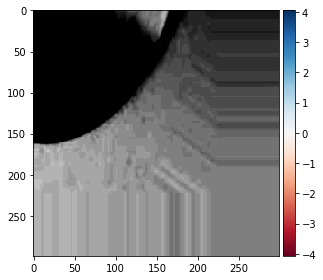

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


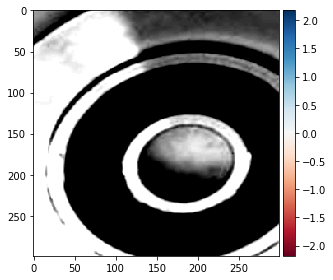

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


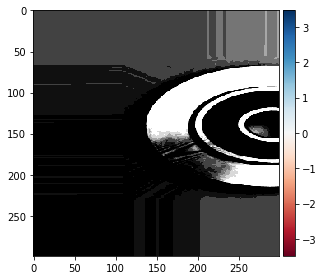

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


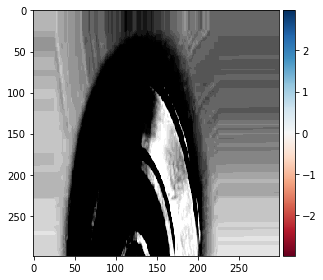

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


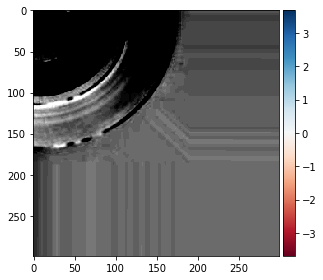

In [63]:
from skimage import io
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = training_set.next()
for i in range(0,5):
    image = x[i]
    imshow(image)


In [93]:
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
metrics = tfa.metrics.F1Score(num_classes = 2,average = "macro",name = "f1_score")
callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=5, mode='max')
reducelr = tf.keras.callbacks.ReduceLROnPlateau( monitor= "val_f1_score",mode='max',factor=0.1,patience=2,verbose=1)

In [94]:
IMAGE_SIZE=[299, 299]

In [66]:
feautre_Ext=Xception(input_shape=IMAGE_SIZE + [3], include_top=False)

In [67]:
for layer in feautre_Ext.layers:
    layer.trainable = False

In [68]:
x = Flatten()(feautre_Ext.output)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=feautre_Ext.input, outputs=prediction)

In [44]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [95]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
save_weights_only=True,save_best_only=True,verbose=1,monitor= "val_f1_score",mode='max')

In [99]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[metrics])

In [72]:
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=3600, verbose=0)

In [73]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

209/209 [==============================] - 1005s 5s/step - loss: 0.8076 - f1_score: 0.4966 - val_loss: 0.7164 - val_f1_score: 0.4062

Epoch 00001: val_f1_score improved from -inf to 0.40623, saving model to training_1/cp.ckpt


In [97]:
feau_extractor = NASNetLarge(input_shape=IMAGE_SIZE+[3], include_top=False,weights=None)
for layer in feau_extractor.layers:
    layer.trainable = False
x = Flatten()(feau_extractor.output)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=feau_extractor.input, outputs=prediction)


In [100]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

209/209 [==============================] - 254s 1s/step - loss: 1.3248 - f1_score: 0.4895 - val_loss: 0.7947 - val_f1_score: 0.3545

Epoch 00001: val_f1_score improved from -inf to 0.35449, saving model to training_1/cp.ckpt


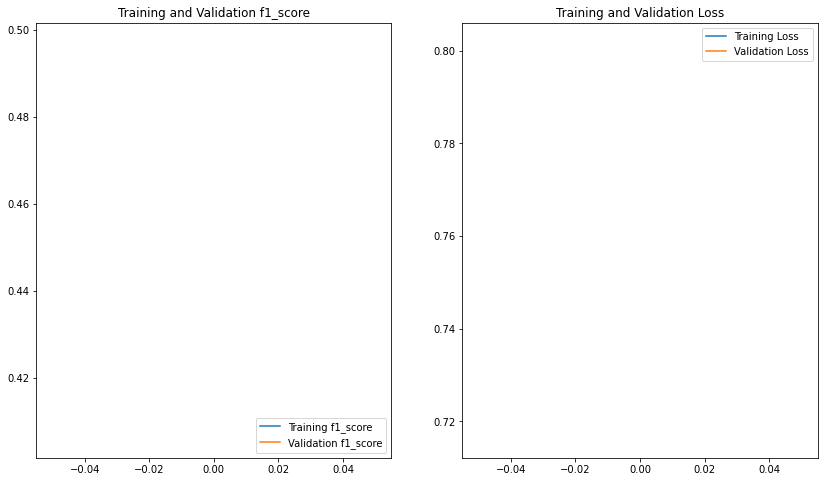

In [74]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,